In [1]:
%matplotlib inline
import argparse
import os
import random
import argparse
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from PIL import Image

In [2]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# set a manual seed to prevent different result while every running

manualSeed = 999
print("Random seed:", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random seed: 999


In [4]:
data_root = "/content/gdrive/MyDrive/GIDS/CAN_image_dataset(L)/" 
data_save = "/content/gdrive/MyDrive/GIDS/" 

workers = 1                 # using thread numbers
batch_size = 128            # batch_size
nc = 1                      # number of channel from input images
num_epochs = 100             # number of training epochs
lr = 0.0001                 # learning rate
beta1 = 0.5                 # hyperparameter for adam optimizer
ngpu = 1                    # number of available gpu

In [5]:
dataset = dset.ImageFolder(root=data_root,
                           transform=transforms.Compose([
                                transforms.Resize((64,48)),
                               transforms.Grayscale(1),
                               transforms.ToTensor(),
                           ]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size = batch_size,shuffle=False,num_workers=workers,persistent_workers= True)
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

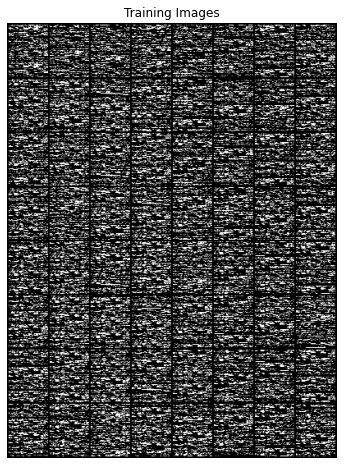

In [6]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis('off')
plt.title('Training Images')
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2,normalize=True).cpu(),(1,2,0)))

In [7]:
class PrintLayer(nn.Module):
    def __init__(self):
        super(PrintLayer, self).__init__()

    def forward(self, x):
        # Do your print / debug stuff here
        print(x)
        return x

In [8]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [9]:
# v1 : except nn.BatchNorm2d(channel size)

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # Input : N x channel noise x 1 x 1
            nn.ConvTranspose2d(256,512,(4,3),stride=1,bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            # second layer
            nn.ConvTranspose2d(512,256,4,stride=2,padding=1,bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # third layer
            nn.ConvTranspose2d(256,128,4,stride=2,padding=1,bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # fourth layer,
            nn.ConvTranspose2d(128,64,4,stride=2,padding=1,bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # Final layer
            nn.ConvTranspose2d(64,1,4,stride=2,padding=1,bias=False),
            nn.Tanh()
        )
    def forward(self,input):
        #x = self.main(input)
        #print("generated output shape: ",x.shape)
        return self.main(input)

In [10]:
netG = Generator(ngpu).to(device)

if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG,list(range(ngpu)))

netG.apply(weights_init)

print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(256, 512, kernel_size=(4, 3), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [11]:
class Discriminator(nn.Module):
    def __init__(self,ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu,
        self.main = nn.Sequential(
            nn.Conv2d(1,1,(4,3),stride=(2,1),padding=1,bias=False),
            nn.BatchNorm2d(1),
            nn.ReLU(True),
            nn.Conv2d(1,1,(4,3),stride=(2,1),padding=1,bias=False),
            nn.BatchNorm2d(1),
            nn.ReLU(True),
            nn.Conv2d(1,1,(16,48),stride=1,padding=0,bias=False),
            nn.Sigmoid()
        )
    def forward(self, input):
       #x = self.main(input)
       # print("Discriminator output shape: ", x.shape)
        return self.main(input)

In [12]:
netD = Discriminator(ngpu).to(device)

if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD,list(range(ngpu)))

netD.apply(weights_init)

print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 1, kernel_size=(4, 3), stride=(2, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(1, 1, kernel_size=(4, 3), stride=(2, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(1, 1, kernel_size=(16, 48), stride=(1, 1), bias=False)
    (7): Sigmoid()
  )
)


In [13]:
device

device(type='cpu')

In [14]:
#download the models to acheive the training
netD.load_state_dict(torch.load(f=f"/{data_save}/saved_model/discriminator/discriminator_epoch_60_.pth", map_location=torch.device(device)))
netD.to(device)
netG.load_state_dict(torch.load(f=f"/{data_save}/saved_model/generator/generator_epoch_60_.pth", map_location=torch.device(device)))
netG.to(device)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(256, 512, kernel_size=(4, 3), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [15]:
criterion = nn.BCELoss()
fixed_noise = torch.randn(64,256,1,1,device=device)

real_label = 1
fake_label = 0

optimizerD = optim.Adam(netD.parameters(), lr = lr, betas = (beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr = lr, betas = (beta1, 0.999))

In [16]:
# train process0
epochs = 100
img_list = []
G_losses = []
D_losses = []
def train():
  from tqdm import tqdm
  import time
  from utils import save_model
  # save losses to check training state
  #img_list = []
  #G_losses = []
  #D_losses = []
  iters = 0

  print("Starting Training Loop...")

  # iterate epoch
  for epoch in tqdm(range(num_epochs)):
      # iterate batch in an epoch
      for i ,data in enumerate(dataloader,0):
          ####################
          # (1) update discriminator network : maximize log(D(x)) + log(1 - D(G(z))))
          ####################
          # @@train real data@@
          netD.zero_grad()
          # Adapt to the size of the batches or the device to be used
          real_cpu = data[0].to(device)
          b_size = real_cpu.size(0)
          #print("data: ", data[0].shape)
          label = torch.full((b_size,), real_label,
                            dtype=torch.float, device= device)
          # pass batch composed real data to D
          output = netD(real_cpu).view(-1)
          # get losses
          errD_real = criterion(output,label)
          # calculate degree of change while doing backpropagation
          errD_real.backward()
          D_x = output.mean().item()

          # @@ train fake data @@
          # Generate latent space vector used in Generator
          noise = torch.randn(b_size,256,1,1,device=device)
          
          # Generate fake image using G
          fake = netG(noise)
          label.fill_(fake_label)
          # Discriminate truth of data using D
          output = netD(fake.detach()).view(-1)
          # Calculate losses of D
          errD_fake = criterion(output,label)
          # Calculate changes through backpropagation and accumulate changes which get before
          errD_fake.backward()
          D_G_z1 = output.mean().item()
          # add losses which get from both fake image and real image
          # At this time, errD is not used in backpropagation, but is used when reporting the learning state afterwards.
          errD = errD_fake +errD_real

          # Update D
          optimizerD.step()

          ###################
          # (2) Update G network : maximize log(D(G(z)))
          ###################
          netG.zero_grad()
          label.fill_(real_label) # we use real label to get losses of Generator
          # Pass fake data to D again because we update D just now
          # At this time, G didn't update, but we get different value because D update
          output = netD(fake).view(-1)
          # get losses of G
          errG = criterion(output,label)
          # Calculate changes of G
          errG.backward()
          D_G_z2 = output.mean().item()
          # Update G
          optimizerG.step()
          
          

          # print training state
          if i % 50 == 0:
              print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                    % (epoch, num_epochs, i, len(dataloader),
                      errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

          # save losses to draw graph later
          G_losses.append(errG.item())
          D_losses.append(errD.item())

          # save return value of G passed fixed noise
          if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
              with torch.no_grad():
                  fake = netG(fixed_noise).detach().cpu()
              img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
              save_model(model=netD,target_dir=f"{data_save}/saved_model/discriminator",model_name=f"discriminator_1_{epoch}.pth")
              save_model(model=netG,target_dir=f"{data_save}/saved_model/generator",model_name=f"generator_1_{epoch}.pth")
          iters += 1



In [19]:
train()

Starting Training Loop...


  0%|          | 0/100 [00:00<?, ?it/s]

[0/100][0/44]	Loss_D: 1.5947	Loss_G: 0.8706	D(x): 0.3535	D(G(z)): 0.4223 / 0.4187
[INFO] Saving model to: /content/gdrive/MyDrive/GIDS/saved_model/discriminator/discriminator_1_0.pth
[INFO] Saving model to: /content/gdrive/MyDrive/GIDS/saved_model/generator/generator_1_0.pth


  1%|          | 1/100 [02:14<3:41:23, 134.18s/it]

[1/100][0/44]	Loss_D: 1.5766	Loss_G: 0.6168	D(x): 0.4618	D(G(z)): 0.5508 / 0.5397


  2%|▏         | 2/100 [04:19<3:31:04, 129.23s/it]

[2/100][0/44]	Loss_D: 1.5316	Loss_G: 0.7519	D(x): 0.4201	D(G(z)): 0.4836 / 0.4715


  3%|▎         | 3/100 [06:22<3:23:51, 126.10s/it]

[3/100][0/44]	Loss_D: 1.5275	Loss_G: 0.6749	D(x): 0.4541	D(G(z)): 0.5209 / 0.5092


  4%|▍         | 4/100 [08:26<3:20:16, 125.17s/it]

[4/100][0/44]	Loss_D: 1.4767	Loss_G: 0.8056	D(x): 0.4225	D(G(z)): 0.4585 / 0.4468


  5%|▌         | 5/100 [10:30<3:17:58, 125.04s/it]

[5/100][0/44]	Loss_D: 1.4958	Loss_G: 0.7453	D(x): 0.4327	D(G(z)): 0.4815 / 0.4746


  6%|▌         | 6/100 [12:36<3:16:02, 125.13s/it]

[6/100][0/44]	Loss_D: 1.4674	Loss_G: 0.8299	D(x): 0.4151	D(G(z)): 0.4441 / 0.4361


  7%|▋         | 7/100 [14:41<3:13:54, 125.10s/it]

[7/100][0/44]	Loss_D: 1.4541	Loss_G: 0.7694	D(x): 0.4397	D(G(z)): 0.4683 / 0.4633


  8%|▊         | 8/100 [16:44<3:11:03, 124.60s/it]

[8/100][0/44]	Loss_D: 1.5539	Loss_G: 0.7319	D(x): 0.4173	D(G(z)): 0.4929 / 0.4810


  9%|▉         | 9/100 [18:48<3:08:37, 124.37s/it]

[9/100][0/44]	Loss_D: 1.6261	Loss_G: 0.6902	D(x): 0.4124	D(G(z)): 0.5228 / 0.5015


 10%|█         | 10/100 [20:51<3:05:58, 123.98s/it]

[10/100][0/44]	Loss_D: 1.5234	Loss_G: 0.7110	D(x): 0.4325	D(G(z)): 0.4959 / 0.4911


 11%|█         | 11/100 [22:56<3:04:20, 124.27s/it]

[11/100][0/44]	Loss_D: 1.4217	Loss_G: 0.7439	D(x): 0.4640	D(G(z)): 0.4799 / 0.4752
[INFO] Saving model to: /content/gdrive/MyDrive/GIDS/saved_model/discriminator/discriminator_1_11.pth
[INFO] Saving model to: /content/gdrive/MyDrive/GIDS/saved_model/generator/generator_1_11.pth


 12%|█▏        | 12/100 [25:02<3:02:46, 124.62s/it]

[12/100][0/44]	Loss_D: 1.3922	Loss_G: 0.7207	D(x): 0.4875	D(G(z)): 0.4902 / 0.4864


 13%|█▎        | 13/100 [27:05<3:00:10, 124.26s/it]

[13/100][0/44]	Loss_D: 1.4508	Loss_G: 0.6662	D(x): 0.4872	D(G(z)): 0.5189 / 0.5136


 14%|█▍        | 14/100 [29:09<2:58:00, 124.19s/it]

[14/100][0/44]	Loss_D: 1.3910	Loss_G: 0.7047	D(x): 0.4943	D(G(z)): 0.4966 / 0.4943


 15%|█▌        | 15/100 [31:41<3:07:39, 132.46s/it]

[15/100][0/44]	Loss_D: 1.3913	Loss_G: 0.7010	D(x): 0.4971	D(G(z)): 0.4995 / 0.4961


 16%|█▌        | 16/100 [33:46<3:02:20, 130.25s/it]

[16/100][0/44]	Loss_D: 1.3790	Loss_G: 0.6848	D(x): 0.5107	D(G(z)): 0.5069 / 0.5042


 17%|█▋        | 17/100 [35:49<2:57:03, 128.00s/it]

[17/100][0/44]	Loss_D: 1.3139	Loss_G: 0.7088	D(x): 0.5314	D(G(z)): 0.4941 / 0.4922


 18%|█▊        | 18/100 [37:52<2:53:12, 126.73s/it]

[18/100][0/44]	Loss_D: 1.3244	Loss_G: 0.6866	D(x): 0.5391	D(G(z)): 0.5065 / 0.5033


 19%|█▉        | 19/100 [39:57<2:50:18, 126.16s/it]

[19/100][0/44]	Loss_D: 1.4518	Loss_G: 0.6222	D(x): 0.5118	D(G(z)): 0.5425 / 0.5368


 20%|██        | 20/100 [41:59<2:46:37, 124.97s/it]

[20/100][0/44]	Loss_D: 1.3408	Loss_G: 0.6783	D(x): 0.5330	D(G(z)): 0.5091 / 0.5075


 21%|██        | 21/100 [44:02<2:43:41, 124.33s/it]

[21/100][0/44]	Loss_D: 1.3287	Loss_G: 0.6581	D(x): 0.5519	D(G(z)): 0.5201 / 0.5179


 22%|██▏       | 22/100 [46:09<2:42:31, 125.02s/it]

[22/100][0/44]	Loss_D: 1.2973	Loss_G: 0.7103	D(x): 0.5415	D(G(z)): 0.4952 / 0.4915
[INFO] Saving model to: /content/gdrive/MyDrive/GIDS/saved_model/discriminator/discriminator_1_22.pth
[INFO] Saving model to: /content/gdrive/MyDrive/GIDS/saved_model/generator/generator_1_22.pth


 23%|██▎       | 23/100 [48:13<2:40:15, 124.87s/it]

[23/100][0/44]	Loss_D: 1.3979	Loss_G: 0.6882	D(x): 0.5060	D(G(z)): 0.5115 / 0.5025


 24%|██▍       | 24/100 [50:16<2:37:17, 124.18s/it]

[24/100][0/44]	Loss_D: 1.3587	Loss_G: 0.7136	D(x): 0.5078	D(G(z)): 0.4937 / 0.4899


 25%|██▌       | 25/100 [52:21<2:35:26, 124.35s/it]

[25/100][0/44]	Loss_D: 1.3351	Loss_G: 0.7147	D(x): 0.5183	D(G(z)): 0.4922 / 0.4894


 26%|██▌       | 26/100 [54:23<2:32:42, 123.82s/it]

[26/100][0/44]	Loss_D: 1.3684	Loss_G: 0.7058	D(x): 0.5065	D(G(z)): 0.4974 / 0.4937


 27%|██▋       | 27/100 [56:26<2:30:22, 123.60s/it]

[27/100][0/44]	Loss_D: 1.2414	Loss_G: 0.7423	D(x): 0.5531	D(G(z)): 0.4774 / 0.4760


 28%|██▊       | 28/100 [58:31<2:28:51, 124.06s/it]

[28/100][0/44]	Loss_D: 1.2922	Loss_G: 0.7291	D(x): 0.5343	D(G(z)): 0.4858 / 0.4824


 29%|██▉       | 29/100 [1:00:33<2:26:03, 123.43s/it]

[29/100][0/44]	Loss_D: 1.3205	Loss_G: 0.6783	D(x): 0.5462	D(G(z)): 0.5110 / 0.5075


 30%|███       | 30/100 [1:02:36<2:23:39, 123.14s/it]

[30/100][0/44]	Loss_D: 1.4107	Loss_G: 0.5987	D(x): 0.5532	D(G(z)): 0.5588 / 0.5495


 31%|███       | 31/100 [1:04:40<2:22:01, 123.51s/it]

[31/100][0/44]	Loss_D: 1.4359	Loss_G: 0.6473	D(x): 0.5086	D(G(z)): 0.5320 / 0.5235


 32%|███▏      | 32/100 [1:06:44<2:20:09, 123.67s/it]

[32/100][0/44]	Loss_D: 1.3701	Loss_G: 0.7345	D(x): 0.4944	D(G(z)): 0.4859 / 0.4797


 33%|███▎      | 33/100 [1:08:47<2:17:48, 123.41s/it]

[33/100][0/44]	Loss_D: 1.3329	Loss_G: 0.7978	D(x): 0.4817	D(G(z)): 0.4522 / 0.4503


 34%|███▍      | 34/100 [1:10:51<2:16:01, 123.65s/it]

[34/100][0/44]	Loss_D: 1.4096	Loss_G: 0.6327	D(x): 0.5314	D(G(z)): 0.5401 / 0.5312
[INFO] Saving model to: /content/gdrive/MyDrive/GIDS/saved_model/discriminator/discriminator_1_34.pth
[INFO] Saving model to: /content/gdrive/MyDrive/GIDS/saved_model/generator/generator_1_34.pth


 35%|███▌      | 35/100 [1:12:56<2:14:21, 124.03s/it]

[35/100][0/44]	Loss_D: 1.3902	Loss_G: 0.7121	D(x): 0.4931	D(G(z)): 0.4947 / 0.4906


 36%|███▌      | 36/100 [1:14:59<2:11:59, 123.74s/it]

[36/100][0/44]	Loss_D: 1.2925	Loss_G: 0.7314	D(x): 0.5336	D(G(z)): 0.4852 / 0.4812


 37%|███▋      | 37/100 [1:17:04<2:10:10, 123.97s/it]

[37/100][0/44]	Loss_D: 1.4440	Loss_G: 0.6076	D(x): 0.5308	D(G(z)): 0.5552 / 0.5447


 38%|███▊      | 38/100 [1:19:06<2:07:38, 123.53s/it]

[38/100][0/44]	Loss_D: 1.3117	Loss_G: 0.7456	D(x): 0.5156	D(G(z)): 0.4773 / 0.4744


 39%|███▉      | 39/100 [1:21:08<2:05:10, 123.12s/it]

[39/100][0/44]	Loss_D: 1.3675	Loss_G: 0.6573	D(x): 0.5355	D(G(z)): 0.5240 / 0.5183


 40%|████      | 40/100 [1:23:12<2:03:12, 123.20s/it]

[40/100][0/44]	Loss_D: 1.3959	Loss_G: 0.7042	D(x): 0.4944	D(G(z)): 0.4989 / 0.4945


 41%|████      | 41/100 [1:25:15<2:01:12, 123.26s/it]

[41/100][0/44]	Loss_D: 1.2105	Loss_G: 0.7763	D(x): 0.5530	D(G(z)): 0.4608 / 0.4601


 42%|████▏     | 42/100 [1:27:18<1:58:56, 123.04s/it]

[42/100][0/44]	Loss_D: 1.2723	Loss_G: 0.6987	D(x): 0.5637	D(G(z)): 0.5027 / 0.4972


 43%|████▎     | 43/100 [1:29:20<1:56:42, 122.85s/it]

[43/100][0/44]	Loss_D: 1.5067	Loss_G: 0.5315	D(x): 0.5555	D(G(z)): 0.6007 / 0.5877


 44%|████▍     | 44/100 [1:31:26<1:55:21, 123.60s/it]

[44/100][0/44]	Loss_D: 1.4768	Loss_G: 0.6583	D(x): 0.4839	D(G(z)): 0.5275 / 0.5178


 45%|████▌     | 45/100 [1:33:30<1:53:30, 123.83s/it]

[45/100][0/44]	Loss_D: 1.2977	Loss_G: 0.7266	D(x): 0.5330	D(G(z)): 0.4871 / 0.4835
[INFO] Saving model to: /content/gdrive/MyDrive/GIDS/saved_model/discriminator/discriminator_1_45.pth
[INFO] Saving model to: /content/gdrive/MyDrive/GIDS/saved_model/generator/generator_1_45.pth


 46%|████▌     | 46/100 [1:35:36<1:51:57, 124.39s/it]

[46/100][0/44]	Loss_D: 1.2969	Loss_G: 0.6730	D(x): 0.5629	D(G(z)): 0.5139 / 0.5102


 47%|████▋     | 47/100 [1:37:39<1:49:32, 124.02s/it]

[47/100][0/44]	Loss_D: 1.2464	Loss_G: 0.7222	D(x): 0.5657	D(G(z)): 0.4913 / 0.4857


 48%|████▊     | 48/100 [1:39:42<1:47:09, 123.65s/it]

[48/100][0/44]	Loss_D: 1.3112	Loss_G: 0.7182	D(x): 0.5347	D(G(z)): 0.4955 / 0.4876


 49%|████▉     | 49/100 [1:52:26<4:28:30, 315.89s/it]

[49/100][0/44]	Loss_D: 1.3487	Loss_G: 0.7119	D(x): 0.5157	D(G(z)): 0.4963 / 0.4907


 50%|█████     | 50/100 [1:54:30<3:35:16, 258.34s/it]

[50/100][0/44]	Loss_D: 1.3169	Loss_G: 0.6365	D(x): 0.5743	D(G(z)): 0.5330 / 0.5291


 51%|█████     | 51/100 [1:56:35<2:58:18, 218.33s/it]

[51/100][0/44]	Loss_D: 1.2852	Loss_G: 0.6309	D(x): 0.6031	D(G(z)): 0.5410 / 0.5321


 52%|█████▏    | 52/100 [1:58:40<2:32:22, 190.47s/it]

[52/100][0/44]	Loss_D: 1.2819	Loss_G: 0.6844	D(x): 0.5687	D(G(z)): 0.5116 / 0.5044


 53%|█████▎    | 53/100 [2:00:47<2:14:03, 171.14s/it]

[53/100][0/44]	Loss_D: 1.2050	Loss_G: 0.7340	D(x): 0.5862	D(G(z)): 0.4883 / 0.4800


 54%|█████▍    | 54/100 [2:02:50<2:00:18, 156.92s/it]

[54/100][0/44]	Loss_D: 1.1915	Loss_G: 0.7119	D(x): 0.6071	D(G(z)): 0.4991 / 0.4907


 55%|█████▌    | 55/100 [2:04:54<1:50:15, 147.00s/it]

[55/100][0/44]	Loss_D: 1.6575	Loss_G: 0.5438	D(x): 0.4751	D(G(z)): 0.5982 / 0.5806


 56%|█████▌    | 56/100 [2:07:00<1:43:09, 140.67s/it]

[56/100][0/44]	Loss_D: 1.3776	Loss_G: 0.7077	D(x): 0.5095	D(G(z)): 0.5043 / 0.4928
[INFO] Saving model to: /content/gdrive/MyDrive/GIDS/saved_model/discriminator/discriminator_1_56.pth
[INFO] Saving model to: /content/gdrive/MyDrive/GIDS/saved_model/generator/generator_1_56.pth


 57%|█████▋    | 57/100 [2:09:06<1:37:39, 136.26s/it]

[57/100][0/44]	Loss_D: 1.4838	Loss_G: 0.7707	D(x): 0.4293	D(G(z)): 0.4711 / 0.4627


 58%|█████▊    | 58/100 [2:11:12<1:33:11, 133.13s/it]

[58/100][0/44]	Loss_D: 1.4965	Loss_G: 0.6116	D(x): 0.4995	D(G(z)): 0.5513 / 0.5425


 59%|█████▉    | 59/100 [2:13:16<1:29:06, 130.41s/it]

[59/100][0/44]	Loss_D: 1.6274	Loss_G: 0.5658	D(x): 0.4740	D(G(z)): 0.5851 / 0.5679


 60%|██████    | 60/100 [2:15:20<1:25:41, 128.53s/it]

[60/100][0/44]	Loss_D: 1.4520	Loss_G: 0.7137	D(x): 0.4646	D(G(z)): 0.4957 / 0.4898


 61%|██████    | 61/100 [2:17:24<1:22:44, 127.31s/it]

[61/100][0/44]	Loss_D: 1.3672	Loss_G: 0.7582	D(x): 0.4818	D(G(z)): 0.4706 / 0.4685


 62%|██████▏   | 62/100 [2:19:28<1:19:51, 126.09s/it]

[62/100][0/44]	Loss_D: 1.3144	Loss_G: 0.7438	D(x): 0.5164	D(G(z)): 0.4794 / 0.4753


 63%|██████▎   | 63/100 [3:05:28<9:25:09, 916.46s/it]

[63/100][0/44]	Loss_D: 1.2881	Loss_G: 0.7268	D(x): 0.5372	D(G(z)): 0.4862 / 0.4835


 64%|██████▍   | 64/100 [3:07:31<6:47:02, 678.41s/it]

[64/100][0/44]	Loss_D: 1.4322	Loss_G: 0.6030	D(x): 0.5349	D(G(z)): 0.5533 / 0.5471


 65%|██████▌   | 65/100 [3:09:35<4:58:41, 512.04s/it]

[65/100][0/44]	Loss_D: 1.3821	Loss_G: 0.7185	D(x): 0.4932	D(G(z)): 0.4906 / 0.4875


 66%|██████▌   | 66/100 [3:11:39<3:44:12, 395.66s/it]

[66/100][0/44]	Loss_D: 1.3046	Loss_G: 0.6922	D(x): 0.5464	D(G(z)): 0.5031 / 0.5005


 67%|██████▋   | 67/100 [3:13:42<2:52:37, 313.87s/it]

[67/100][0/44]	Loss_D: 1.2922	Loss_G: 0.7842	D(x): 0.5079	D(G(z)): 0.4588 / 0.4565


 68%|██████▊   | 68/100 [3:15:50<2:17:34, 257.94s/it]

[68/100][0/44]	Loss_D: 1.4359	Loss_G: 0.6014	D(x): 0.5344	D(G(z)): 0.5545 / 0.5481
[INFO] Saving model to: /content/gdrive/MyDrive/GIDS/saved_model/discriminator/discriminator_1_68.pth
[INFO] Saving model to: /content/gdrive/MyDrive/GIDS/saved_model/generator/generator_1_68.pth


 69%|██████▉   | 69/100 [3:17:54<1:52:31, 217.81s/it]

[69/100][0/44]	Loss_D: 1.3746	Loss_G: 0.6970	D(x): 0.5100	D(G(z)): 0.5037 / 0.4981


 70%|███████   | 70/100 [3:19:57<1:34:40, 189.34s/it]

[70/100][0/44]	Loss_D: 1.5795	Loss_G: 0.5749	D(x): 0.4824	D(G(z)): 0.5725 / 0.5627


 71%|███████   | 71/100 [3:22:01<1:22:02, 169.74s/it]

[71/100][0/44]	Loss_D: 1.3684	Loss_G: 0.6828	D(x): 0.5204	D(G(z)): 0.5106 / 0.5052


 72%|███████▏  | 72/100 [3:24:03<1:12:36, 155.59s/it]

[72/100][0/44]	Loss_D: 1.4243	Loss_G: 0.6413	D(x): 0.5215	D(G(z)): 0.5382 / 0.5266


 73%|███████▎  | 73/100 [3:26:08<1:05:46, 146.16s/it]

[73/100][0/44]	Loss_D: 1.4281	Loss_G: 0.6458	D(x): 0.5117	D(G(z)): 0.5312 / 0.5242


 74%|███████▍  | 74/100 [3:28:13<1:00:37, 139.92s/it]

[74/100][0/44]	Loss_D: 1.3513	Loss_G: 0.7007	D(x): 0.5253	D(G(z)): 0.5069 / 0.4962


 75%|███████▌  | 75/100 [3:30:16<56:12, 134.91s/it]  

[75/100][0/44]	Loss_D: 1.4756	Loss_G: 0.6634	D(x): 0.4798	D(G(z)): 0.5232 / 0.5151


 76%|███████▌  | 76/100 [3:32:19<52:30, 131.26s/it]

[76/100][0/44]	Loss_D: 1.4309	Loss_G: 0.6816	D(x): 0.4872	D(G(z)): 0.5089 / 0.5058


 77%|███████▋  | 77/100 [3:34:23<49:29, 129.10s/it]

[77/100][0/44]	Loss_D: 1.3030	Loss_G: 0.7173	D(x): 0.5328	D(G(z)): 0.4897 / 0.4881


 78%|███████▊  | 78/100 [3:36:26<46:41, 127.32s/it]

[78/100][0/44]	Loss_D: 1.2407	Loss_G: 0.7088	D(x): 0.5736	D(G(z)): 0.4955 / 0.4923


 79%|███████▉  | 79/100 [3:38:29<44:07, 126.09s/it]

[79/100][0/44]	Loss_D: 1.2829	Loss_G: 0.6895	D(x): 0.5644	D(G(z)): 0.5085 / 0.5019
[INFO] Saving model to: /content/gdrive/MyDrive/GIDS/saved_model/discriminator/discriminator_1_79.pth
[INFO] Saving model to: /content/gdrive/MyDrive/GIDS/saved_model/generator/generator_1_79.pth


 80%|████████  | 80/100 [3:40:36<42:05, 126.28s/it]

[80/100][0/44]	Loss_D: 1.2611	Loss_G: 0.7528	D(x): 0.5391	D(G(z)): 0.4740 / 0.4710


 81%|████████  | 81/100 [3:42:41<39:50, 125.80s/it]

[81/100][0/44]	Loss_D: 1.4289	Loss_G: 0.6393	D(x): 0.5139	D(G(z)): 0.5335 / 0.5276


 82%|████████▏ | 82/100 [3:44:50<38:05, 126.97s/it]

[82/100][0/44]	Loss_D: 1.4169	Loss_G: 0.6839	D(x): 0.4967	D(G(z)): 0.5115 / 0.5046


 83%|████████▎ | 83/100 [3:46:54<35:40, 125.94s/it]

[83/100][0/44]	Loss_D: 1.3996	Loss_G: 0.6681	D(x): 0.5111	D(G(z)): 0.5170 / 0.5127


 84%|████████▍ | 84/100 [3:48:57<33:23, 125.21s/it]

[84/100][0/44]	Loss_D: 1.3372	Loss_G: 0.6832	D(x): 0.5340	D(G(z)): 0.5080 / 0.5050


 85%|████████▌ | 85/100 [3:51:01<31:10, 124.67s/it]

[85/100][0/44]	Loss_D: 1.3531	Loss_G: 0.6085	D(x): 0.5707	D(G(z)): 0.5468 / 0.5442


 86%|████████▌ | 86/100 [3:53:05<29:01, 124.39s/it]

[86/100][0/44]	Loss_D: 1.3541	Loss_G: 0.6123	D(x): 0.5699	D(G(z)): 0.5466 / 0.5421


 87%|████████▋ | 87/100 [3:55:07<26:50, 123.91s/it]

[87/100][0/44]	Loss_D: 1.5522	Loss_G: 0.6540	D(x): 0.4484	D(G(z)): 0.5272 / 0.5200


 88%|████████▊ | 88/100 [3:57:12<24:49, 124.11s/it]

[88/100][0/44]	Loss_D: 1.6181	Loss_G: 0.6216	D(x): 0.4343	D(G(z)): 0.5431 / 0.5371


 89%|████████▉ | 89/100 [3:59:15<22:42, 123.85s/it]

[89/100][0/44]	Loss_D: 1.5308	Loss_G: 0.6255	D(x): 0.4702	D(G(z)): 0.5395 / 0.5350


 90%|█████████ | 90/100 [4:01:22<20:46, 124.64s/it]

[90/100][0/44]	Loss_D: 1.4338	Loss_G: 0.6642	D(x): 0.4994	D(G(z)): 0.5224 / 0.5147
[INFO] Saving model to: /content/gdrive/MyDrive/GIDS/saved_model/discriminator/discriminator_1_90.pth
[INFO] Saving model to: /content/gdrive/MyDrive/GIDS/saved_model/generator/generator_1_90.pth


 91%|█████████ | 91/100 [4:03:26<18:41, 124.62s/it]

[91/100][0/44]	Loss_D: 1.3889	Loss_G: 0.6933	D(x): 0.5048	D(G(z)): 0.5057 / 0.4999


 92%|█████████▏| 92/100 [4:05:28<16:31, 123.90s/it]

[92/100][0/44]	Loss_D: 1.5024	Loss_G: 0.7208	D(x): 0.4400	D(G(z)): 0.4938 / 0.4864


 93%|█████████▎| 93/100 [4:07:32<14:27, 123.91s/it]

[93/100][0/44]	Loss_D: 1.3326	Loss_G: 0.7050	D(x): 0.5235	D(G(z)): 0.4959 / 0.4941


 94%|█████████▍| 94/100 [4:09:40<12:29, 124.86s/it]

[94/100][0/44]	Loss_D: 1.3855	Loss_G: 0.6549	D(x): 0.5250	D(G(z)): 0.5232 / 0.5195


 95%|█████████▌| 95/100 [4:11:43<10:22, 124.46s/it]

[95/100][0/44]	Loss_D: 1.3595	Loss_G: 0.7050	D(x): 0.5097	D(G(z)): 0.4960 / 0.4941


 96%|█████████▌| 96/100 [4:13:47<08:17, 124.45s/it]

[96/100][0/44]	Loss_D: 1.3094	Loss_G: 0.6858	D(x): 0.5463	D(G(z)): 0.5057 / 0.5037


 97%|█████████▋| 97/100 [4:15:50<06:11, 123.98s/it]

[97/100][0/44]	Loss_D: 1.3016	Loss_G: 0.7154	D(x): 0.5372	D(G(z)): 0.4932 / 0.4890


 98%|█████████▊| 98/100 [4:17:53<04:07, 123.64s/it]

[98/100][0/44]	Loss_D: 1.4219	Loss_G: 0.6597	D(x): 0.5045	D(G(z)): 0.5216 / 0.5170


 99%|█████████▉| 99/100 [4:19:58<02:03, 123.94s/it]

[99/100][0/44]	Loss_D: 1.3678	Loss_G: 0.7224	D(x): 0.4963	D(G(z)): 0.4867 / 0.4856


100%|██████████| 100/100 [4:22:01<00:00, 157.21s/it]

[INFO] Saving model to: /content/gdrive/MyDrive/GIDS/saved_model/discriminator/discriminator_1_99.pth
[INFO] Saving model to: /content/gdrive/MyDrive/GIDS/saved_model/generator/generator_1_99.pth


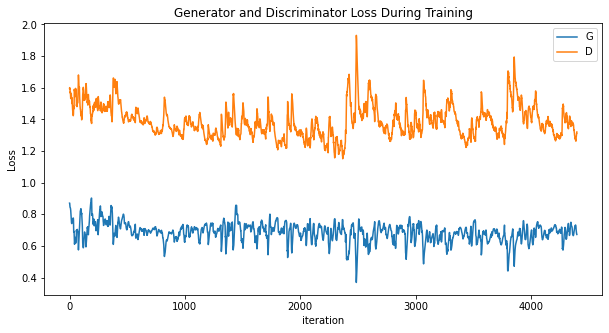

In [20]:
plt.figure(figsize=(10,5))
plt.title('Generator and Discriminator Loss During Training')
plt.plot(G_losses, label='G')
plt.plot(D_losses, label='D')
plt.xlabel('iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.axis('off')
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated = True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000,blit=True)

HTML(ani.to_jshtml())

In [ ]:
# bring real datas form dataloader
real_batch = next(iter(dataloader))

# print real images on display
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis('off')
plt.title('Fake CAN Images')
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [ ]:
netD.load_state_dict(torch.load(f="/content/saved_model/discriminator/discriminator_epoch.pth"))
netD.to(device)
netG.load_state_dict(torch.load(f="/content/saved_model/generator/generator_epoch.pth"))
netG.to(device)

In [ ]:
# train process0
def train():
  from tqdm import tqdm
  import time
  from utils import save_model
  # save losses to check training state
  img_list = []
  G_losses = []
  D_losses = []
  iters = 0

  print("Starting Training Loop...")

  # iterate epoch
  for epoch in tqdm(range(num_epochs)):
      # iterate batch in an epoch
      for i ,data in enumerate(dataloader,0):
          ####################
          # (1) update discriminator network : maximize log(D(x)) + log(1 - D(G(z))))
          ####################
          # @@train real data@@
          netD.zero_grad()
          # Adapt to the size of the batches or the device to be used
          real_cpu = data[0].to(device)
          b_size = real_cpu.size(0)
          #print("data: ", data[0].shape)
          label = torch.full((b_size,), real_label,
                            dtype=torch.float, device= device)
          # pass batch composed real data to D
          output = netD(real_cpu).view(-1)
          # get losses
          errD_real = criterion(output,label)
          # calculate degree of change while doing backpropagation
          errD_real.backward()
          D_x = output.mean().item()

          # @@ train fake data @@
          # Generate latent space vector used in Generator
          noise = torch.randn(b_size,256,1,1,device=device)
          
          # Generate fake image using G
          fake = netG(noise)
          label.fill_(fake_label)
          # Discriminate truth of data using D
          output = netD(fake.detach()).view(-1)
          # Calculate losses of D
          errD_fake = criterion(output,label)
          # Calculate changes through backpropagation and accumulate changes which get before
          errD_fake.backward()
          D_G_z1 = output.mean().item()
          # add losses which get from both fake image and real image
          # At this time, errD is not used in backpropagation, but is used when reporting the learning state afterwards.
          errD = errD_fake +errD_real

          # Update D
          optimizerD.step()

          ###################
          # (2) Update G network : maximize log(D(G(z)))
          ###################
          netG.zero_grad()
          label.fill_(real_label) # we use real label to get losses of Generator
          # Pass fake data to D again because we update D just now
          # At this time, G didn't update, but we get different value because D update
          output = netD(fake).view(-1)
          # get losses of G
          errG = criterion(output,label)
          # Calculate changes of G
          errG.backward()
          D_G_z2 = output.mean().item()
          # Update G
          optimizerG.step()
          
          

          # print training state
          if i % 50 == 0:
              print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                    % (epoch, num_epochs, i, len(dataloader),
                      errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

          # save losses to draw graph later
          G_losses.append(errG.item())
          D_losses.append(errD.item())

          # save return value of G passed fixed noise
          if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
              with torch.no_grad():
                  fake = netG(fixed_noise).detach().cpu()
              img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
              save_model(model=netD,target_dir=f"{data_save}/saved_model/discriminator",model_name=f"discriminator_{epoch}.pth")
              save_model(model=netG,target_dir=f"{data_save}/saved_model/generator",model_name=f"generator_{epoch}.pth")
          iters += 1



In [ ]:
netD.load_state_dict(torch.load(f="/content/saved_model/discriminator/discriminator_epoch_34.pth"))
netD.to(device)
netG.load_state_dict(torch.load(f="/content/saved_model/generator/generator_epoch_34.pth"))
netG.to(device)

In [ ]:
criterion = nn.BCELoss()
fixed_noise = torch.randn(64,256,1,1,device=device)

real_label = 1
fake_label = 0

optimizerD = optim.Adam(netD.parameters(), lr = lr, betas = (beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr = lr, betas = (beta1, 0.999))

In [ ]:
 #train process0
from tqdm import tqdm
import time
from utils import save_model
# save losses to check training state
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")

# iterate epoch
for epoch in tqdm(range(num_epochs)):
    # iterate batch in an epoch
    for i ,data in enumerate(dataloader,0):
        ####################
        # (1) update discriminator network : maximize log(D(x)) + log(1 - D(G(z))))
        ####################
        # @@train real data@@
        netD.zero_grad()
        # Adapt to the size of the batches or the device to be used
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        #print("data: ", data[0].shape)
        label = torch.full((b_size,), real_label,
                           dtype=torch.float, device= device)
        # pass batch composed real data to D
        output = netD(real_cpu).view(-1)
        # get losses
        errD_real = criterion(output,label)
        # calculate degree of change while doing backpropagation
        errD_real.backward()
        D_x = output.mean().item()

        # @@ train fake data @@
        # Generate latent space vector used in Generator
        noise = torch.randn(b_size,256,1,1,device=device)
        
        # Generate fake image using G
        fake = netG(noise)
        label.fill_(fake_label)
        # Discriminate truth of data using D
        output = netD(fake.detach()).view(-1)
        # Calculate losses of D
        errD_fake = criterion(output,label)
        # Calculate changes through backpropagation and accumulate changes which get before
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # add losses which get from both fake image and real image
        # At this time, errD is not used in backpropagation, but is used when reporting the learning state afterwards.
        errD = errD_fake +errD_real

        # Update D
        optimizerD.step()

        ###################
        # (2) Update G network : maximize log(D(G(z)))
        ###################
        netG.zero_grad()
        label.fill_(real_label) # we use real label to get losses of Generator
        # Pass fake data to D again because we update D just now
        # At this time, G didn't update, but we get different value because D update
        output = netD(fake).view(-1)
        # get losses of G
        errG = criterion(output,label)
        # Calculate changes of G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        
        

        # print training state
        if i % 50 == 0:
             print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # save losses to draw graph later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # save return value of G passed fixed noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            save_model(model=netD,target_dir="saved_model/discriminator",model_name=f"discriminator_epoch_{epoch}.pth")
            save_model(model=netG,target_dir="saved_model/generator",model_name=f"generator_epoch_{epoch}.pth")
        iters += 1

